# A comparison between Canny edge detection algorithm and Quantum Hadamard Edge Detection Algorithm

In [1]:
!pip install opencv-python

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
image = cv2.imread('/kaggle/input/logo-a/logo.jpg')

# Detecting Image Edges  using Canny algorithm

In [4]:
def detect_edges(image, low_threshold=100, high_threshold=200):
    edges = cv2.Canny(image, low_threshold, high_threshold)
    plt.figure(figsize=(13,5))

    plt.subplot(1,2,1)

    plt.imshow(image,cmap = 'gray')

    plt.title('Original Image')


    plt.subplot(1,2,2)

    plt.imshow(edges,cmap = 'gray')

    plt.title('Edges detected using Canny algorithm')
    plt.show()

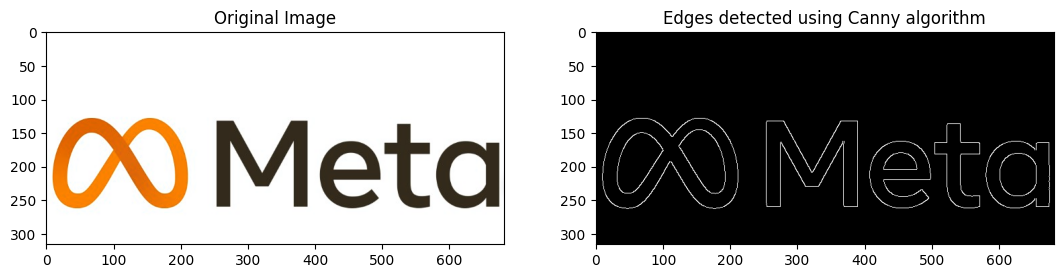

In [5]:
detect_edges(image)

In [6]:
!pip install --quiet qiskit==0.46
!pip install --quiet pylatexenc
!pip install --quiet qiskit_aer

In [7]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import *
import numpy as np
import matplotlib.pyplot as plt

# Image Preprocessing for Quantum Hadamard Edge Detection

(64, 64)

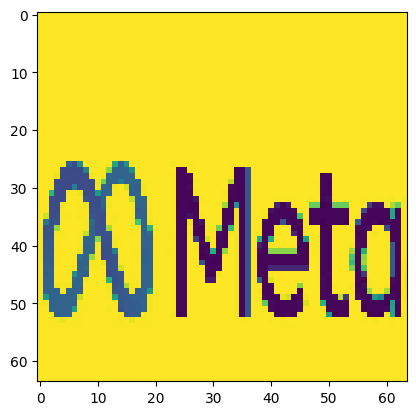

In [8]:
image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Resize the image
image = cv2.resize(image, (64, 64))
image = np.array(image) / 255.0
plt.imshow(image)
image.shape

**The Image quality is degraded due to resizing the image to 64x64x1. We could not resize the image to 256x256x1 because it exceeds the computational resource limit.**

**Here, We are encoding the pixel values to probability amplitudes of the Quantum State**

In [9]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):

    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1))) #first np.sum of each row elements then np.sum of each row

    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)

    # Return the normalized image as a numpy array
    return np.array(image_norm)


# **Horizontal Scan Coefficients**

In [10]:
from qiskit.tools.visualization import array_to_latex
# Horizontal: Original image
h_norm_image = amplitude_encode(image)
print("Horizontal image normalized coefficients")
array_to_latex(h_norm_image,max_size=10)


Horizontal image normalized coefficients


<IPython.core.display.Latex object>

# Vertical Scan Coefficients

In [11]:
# Vertical: Transpose of Original image
v_norm_image = amplitude_encode(image.T)
print("vertical image normalized coefficients")
array_to_latex(v_norm_image,max_size=10)


vertical image normalized coefficients


<IPython.core.display.Latex object>

In [12]:
print("size of 1d array",h_norm_image.shape)
print("size of 1d array",v_norm_image.shape)

size of 1d array (4096,)
size of 1d array (4096,)


# Calculating the number of qubits required

In [13]:
#we require N=log2(64*64) qubits
#N=16

data_q = 12
ancillary_q = 1
total_q = data_q + ancillary_q


**The auxiliary qubit is used to determine the gradients between the pixels**

In [14]:
# Initialize the amplitude permutation unitary
#Decrement Gate
D2n_1 = np.roll(np.identity(2**total_q), 1, axis=1) #np.roll performs a circular shift of the columns of the identity matrix by one positions


In [15]:
D2n_1.shape

(8192, 8192)

/opt/conda/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


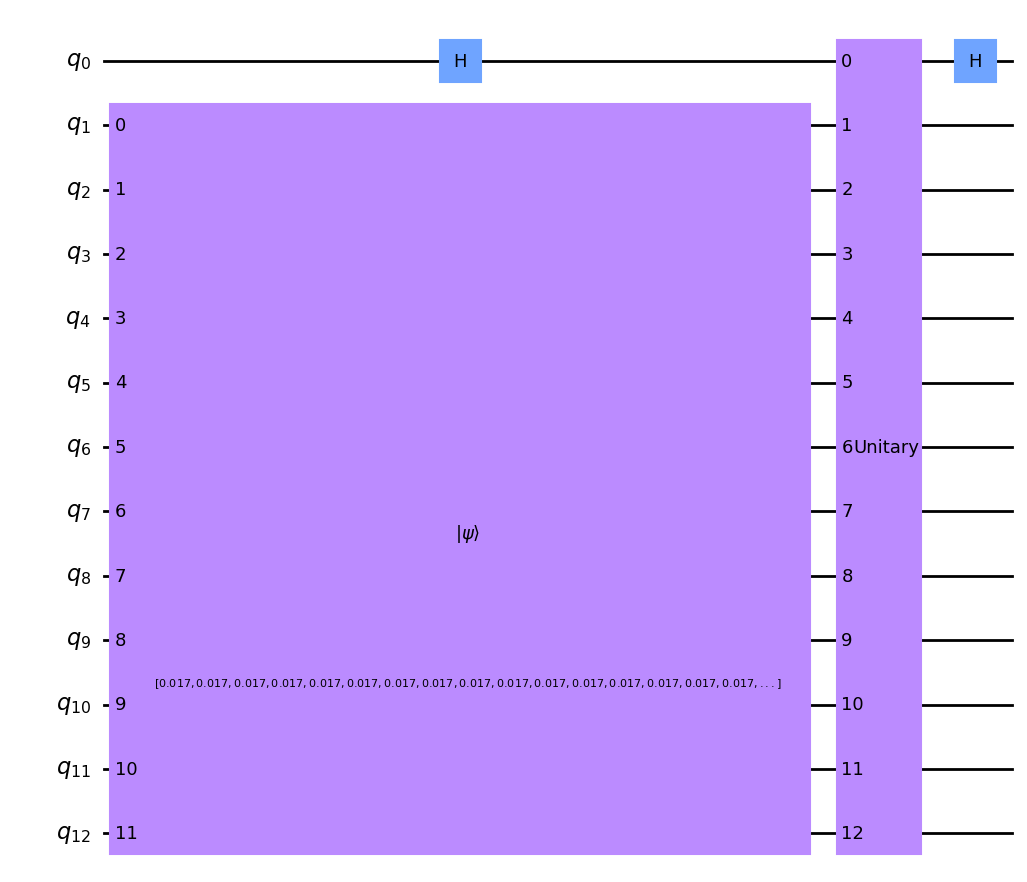

In [16]:
# Creating the circuit for horizontal scan

qc_h = QuantumCircuit(total_q)
qc_h.initialize(h_norm_image, range(1, total_q))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_q))
qc_h.h(0)

display(qc_h.draw('mpl', fold=-1))


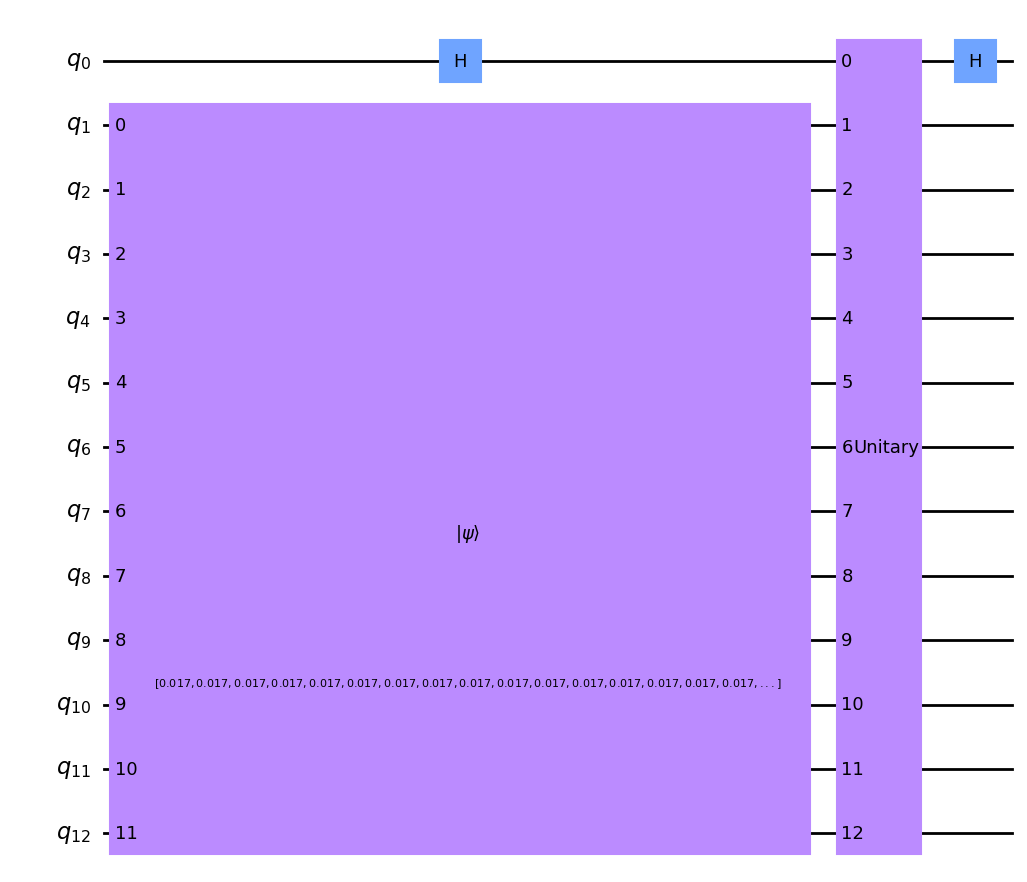

In [17]:
# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_q)
qc_v.initialize(v_norm_image, range(1, total_q))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_q))
qc_v.h(0)

display(qc_v.draw('mpl', fold=-1))

In [18]:
# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [19]:
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
state_vector_h = results.get_statevector(qc_h)
state_vector_v = results.get_statevector(qc_v)
print("print size is ",state_vector_h.size)
from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
display(array_to_latex(state_vector_h, max_size=128))
print()
print('Vertical scan statevector:')
display(array_to_latex(state_vector_v, max_size=128))

/tmp/ipykernel_24/4245977774.py:2: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  results = execute(circ_list, backend=back).result()
/tmp/ipykernel_24/4245977774.py:5: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print("print size is ",state_vector_h.size)


print size is  8192
Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

In [20]:
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='hot')
    plt.show()
    

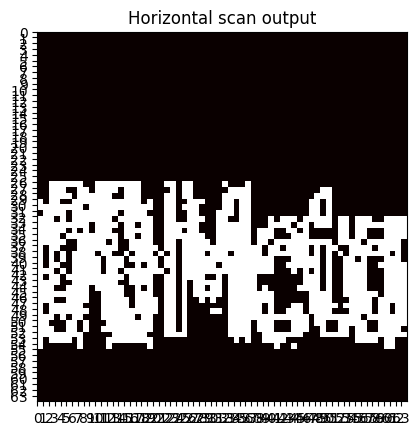

In [21]:
#  postprocessing for plotting the output (Classical)

# Defining a lambda function for thresholding to binary values
# returns true for specified Amplitude values else false
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)


h_edge_scan_img = np.abs(np.array([1 if threshold(state_vector_h[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(64, 64)

# Plotting the Horizontal scan output
plot_image(h_edge_scan_img, 'Horizontal scan output')


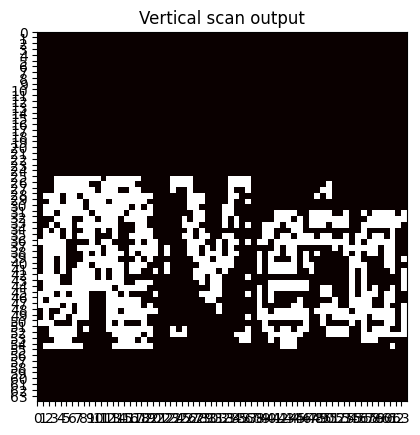

In [22]:
v_edge_scan_img= np.abs(np.array([1 if threshold(state_vector_v[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(64, 64).T
plot_image(v_edge_scan_img, 'Vertical scan output')

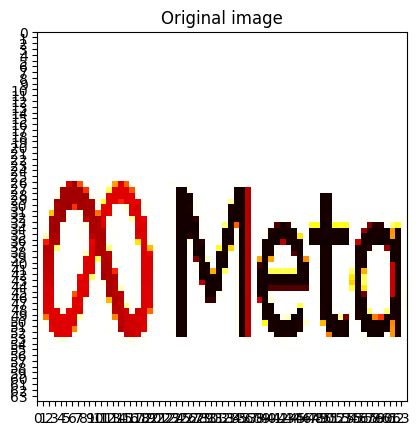

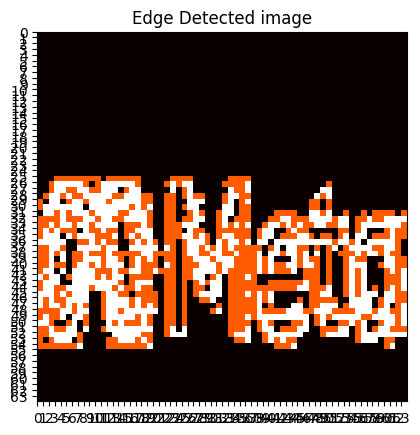

In [23]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = h_edge_scan_img + v_edge_scan_img

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')